# Unit Tests

In [1]:
import importlib
import pytest
import numpy as np
from scipy.signal import unit_impulse as deltafn
from astropy import units as u

import sys
sys.path.append('/home/oliver/PhD/Hacks_and_Mocks/')
import lightkurve as lk

## Numax Test

In [2]:
f = np.arange(0, 4000., 0.4)
p = np.ones(len(f))
nmx = 2500.
fs = f.max()/len(f)

s = 0.25*nmx/2.335    #std of the hump
p *= 10 * np.exp(-0.5*(f-nmx)**2/s**2)  #gaussian profile of the hump

m = np.zeros(len(f))
lo = int(np.floor(.5*nmx/fs))
hi = int(np.floor(1.5*nmx/fs))

dnu_true = 0.294 * nmx ** 0.772
modelocs = np.arange(lo, hi, dnu_true/2, dtype=int)

for modeloc in modelocs:
    m += deltafn(len(f), modeloc)
p *= m
p += 1

### Assert basic return of numax
- [x] Assert numax is within 10% of truth
- [x] Assert numax has values equal to input frequency
- [x] Assert numax works when the input frequency is not in microhertz

In [3]:
snr = lk.periodogram.SNRPeriodogram(f*u.microhertz, u.Quantity(p, None))
numax = snr.estimate_numax()
assert(np.isclose(nmx, numax.value, atol=.1*nmx))  #Assert recovers numax to within 10%
assert(numax.unit == u.microhertz)

In [4]:
fday = u.Quantity(f*u.microhertz, 1/u.day)
snr = lk.periodogram.SNRPeriodogram(fday, u.Quantity(p, None))
numax = snr.estimate_numax()
nmxday = u.Quantity(nmx*u.microhertz, 1/u.day)
assert(np.isclose(nmxday, numax, atol=.1*nmxday))

### Assert estimate_numax() kwargs
- [x] Assert it works with custom numax
- [x] Assert error when numaxs is beyond nyquist or below 0
- [x] Assert numaxs works no matter what unit it is given
- [x] Assert it works when numaxs is given a unit of 1/d rather than microhertz
- [x] Assert it returns a functional plot

In [5]:
# Assert custom numaxs work
snr = lk.periodogram.SNRPeriodogram(f*u.microhertz, u.Quantity(p, None))
numaxs = np.linspace(nmx-2*s, nmx+2*s, 500)
numax = snr.estimate_numax(numaxs=numaxs)
assert(np.isclose(numax.value, nmx, atol=.1*nmx))

In [6]:
# Assert you can't pass custom numaxs outside a easonable range
with pytest.raises(ValueError) as err:
    numax = snr.estimate_numax(numaxs=np.linspace(-5, 5.), show_plots=True)
with pytest.raises(ValueError) as err:
    numax = snr.estimate_numax(numaxs=np.linspace(1., 5000.), show_plots=True)    

In [7]:
# Assert it doesn't matter what units of frequency numaxs are passed in as
daynumaxs = u.Quantity(numaxs*u.microhertz, 1/u.day)
numax = snr.estimate_numax(numaxs=daynumaxs)
assert(np.isclose(numax.value, nmx, atol=.1*nmx))
assert(numax.unit == u.microhertz)

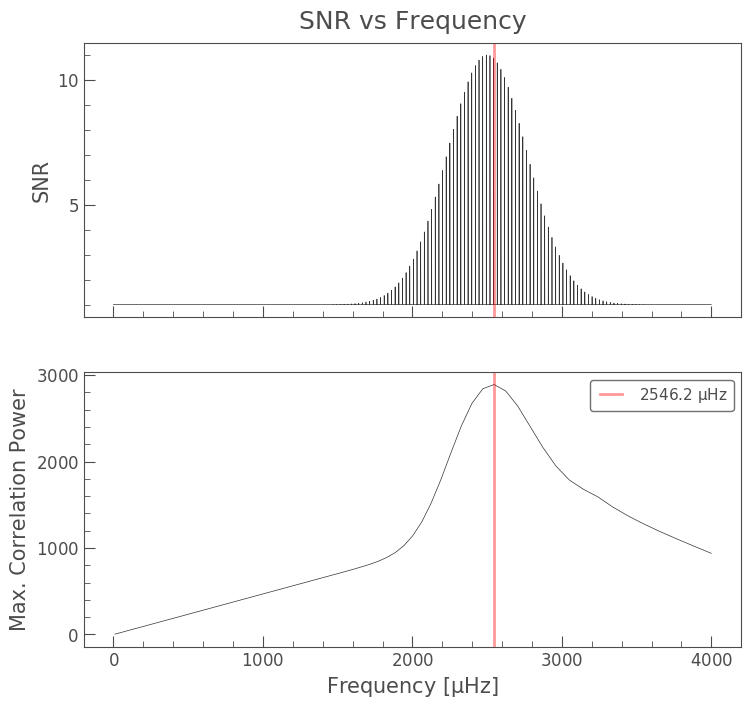

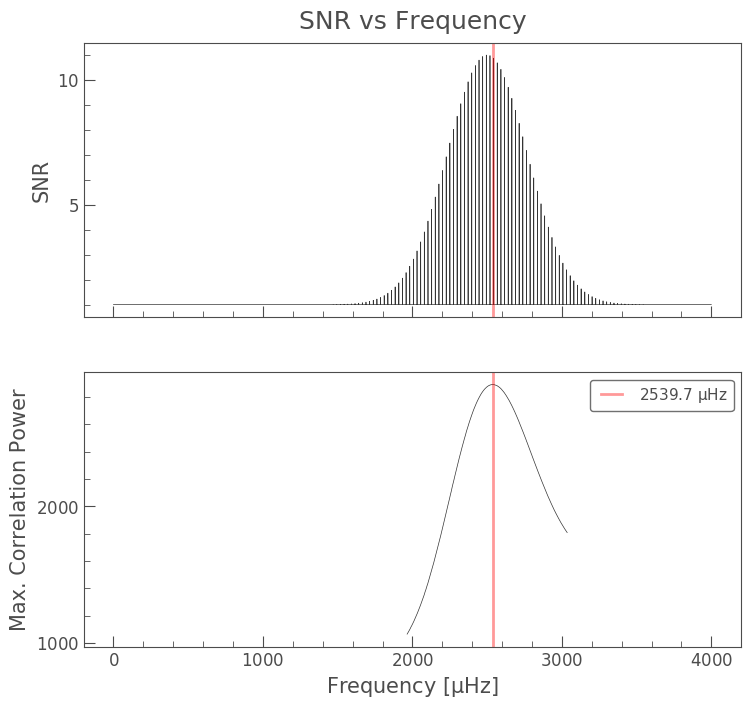

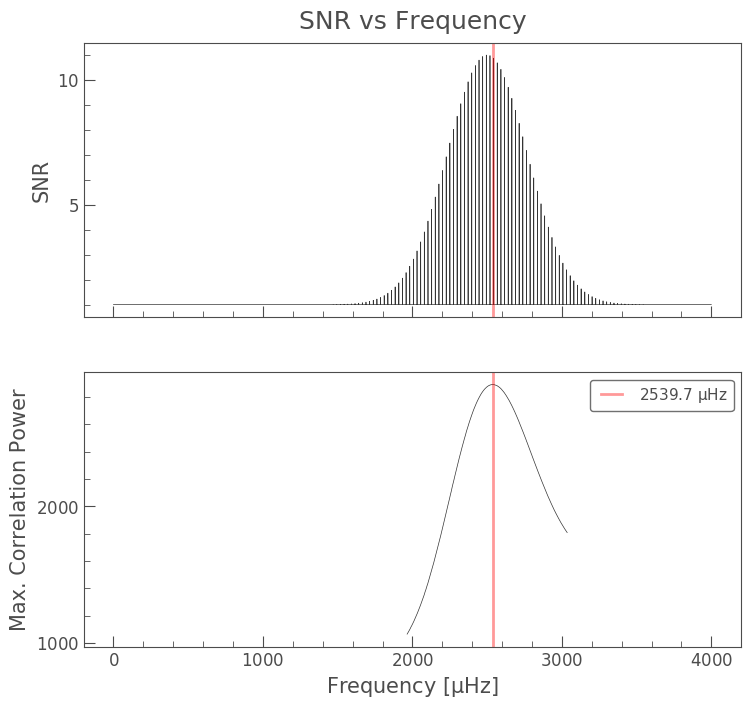

In [8]:
# Sanity check that plotting works under all conditions
numax, ax = snr.estimate_numax(show_plots=True)
numax, ax = snr.estimate_numax(numaxs=numaxs,show_plots=True)
numax, ax = snr.estimate_numax(numaxs=daynumaxs, show_plots=True)

## Dnu Test

In [9]:
f = np.arange(0, 4000., 0.4)
p = np.ones(len(f))
true_numax = 2500.
fs = f.max()/len(f)

s = 0.25*true_numax/2.335    #std of the hump
p *= 10 * np.exp(-0.5*(f-true_numax)**2/s**2)  #gaussian profile of the hump

m = np.zeros(len(f))
lo = int(np.floor(.5*true_numax/fs))
hi = int(np.floor(1.5*true_numax/fs))

true_dnu = 0.294 * true_numax ** 0.772
modelocs = np.arange(lo, hi, dnu_true/2, dtype=int)

for modeloc in modelocs:
    m += deltafn(len(f), modeloc)
p *= m
p += 1

### Assert basic return of dnu
- [x] Assert dnu is within 25% of truth
- [x] Assert dnu has values equal to input frequency
- [x] Assert dnu works when the input frequency is not in microhertz

In [10]:
snr = lk.periodogram.SNRPeriodogram(f*u.microhertz, u.Quantity(p, None))
dnu = snr.estimate_dnu()
assert(np.isclose(true_dnu, dnu.value, atol=.25*true_dnu))  #Assert recovers numax to within 30%
assert(dnu.unit == u.microhertz)

In [11]:
fday = u.Quantity(f*u.microhertz, 1/u.day)
daysnr = lk.periodogram.SNRPeriodogram(fday, u.Quantity(p, None))
dnu = daysnr.estimate_dnu()
dnuday = u.Quantity(true_dnu*u.microhertz, 1/u.day)

assert(np.isclose(dnuday.value, dnu.value, atol=.25*dnuday.value))

### Assert estimate_dnu() kwargs
- [x] Assert it works with custom numax input
- [x] Assert error when input numax is beyond nyquist or below 0
- [x] Assert input numax works no matter what unit it is given
- [x] Assert it returns a functional plot

In [12]:
# Assert custom numax works
snr = lk.periodogram.SNRPeriodogram(f*u.microhertz, u.Quantity(p, None))
numax = snr.estimate_numax(numaxs=numaxs)
dnu = snr.estimate_dnu(numax)
assert(np.isclose(dnu.value, true_dnu, atol=.25*true_dnu))

In [13]:
# Assert you can't pass custom numax outside of appropriate range
with pytest.raises(ValueError) as err:
    dnu = snr.estimate_dnu(numax= -5.)
with pytest.raises(ValueError) as err:
    dnu = snr.estimate_dnu(numax=5000)    

In [16]:
# Assert it doesn't matter what units of frequency numax is passed in as
daynumax = u.Quantity(numax.value*u.microhertz, 1/u.day)
dnu = snr.estimate_dnu(numax=daynumax)
assert(np.isclose(dnu.value, true_dnu, atol=.25*true_dnu))
assert(dnu.unit == u.microhertz)

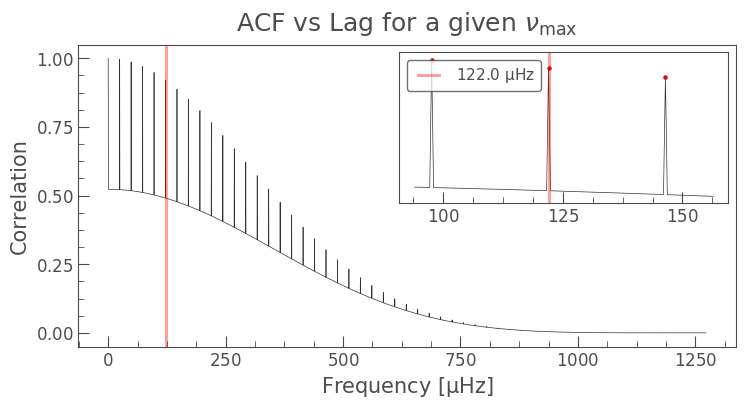

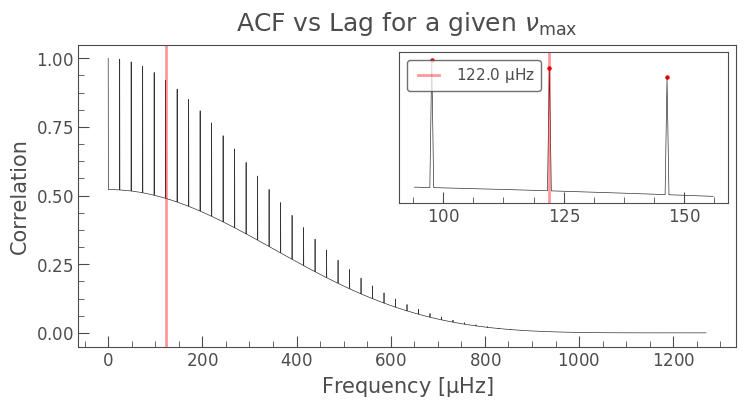

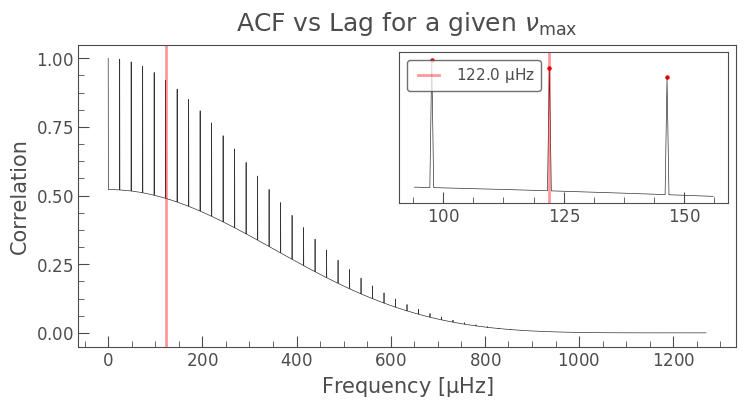

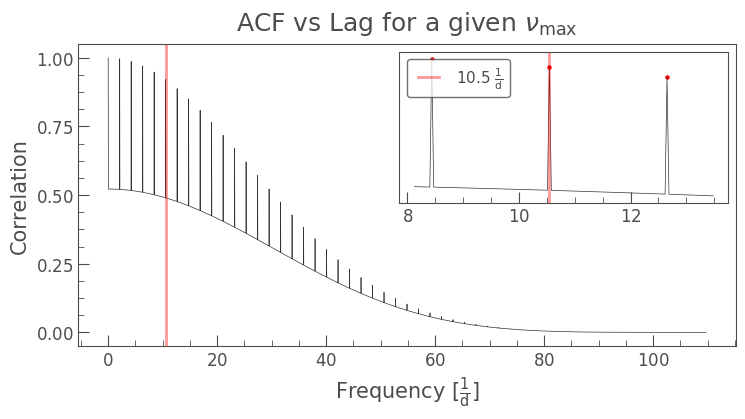

In [17]:
# Sanity check that plotting works under all conditions
dnu, ax = snr.estimate_dnu(show_plots=True)
dnu, ax = snr.estimate_dnu(numax=numax,show_plots=True)
dnu, ax = snr.estimate_dnu(numax=daynumax, show_plots=True)
dnu, ax = daysnr.estimate_dnu(numax=daynumax, show_plots=True)